In [3]:
from io import BytesIO
import requests
import PIL
from PIL import Image
import numpy as np
import os
import uuid
import torch
from torch import autocast
import cv2
from matplotlib import pyplot as plt
from torchvision import transforms

from clipseg.models.clipseg import CLIPDensePredT
import clip

from diffusers import DiffusionPipeline

import sys
from pathlib import Path

/opt/conda/envs/plr/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
model = CLIPDensePredT(version='ViT-B/16', reduce_dim=64)
model.eval()
model.load_state_dict(torch.load('weights/rd64-uni.pth', map_location=torch.device('cuda')), strict=False)

transform = transforms.Compose([
      transforms.ToTensor(),
      transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
      transforms.Resize((512, 512)),
])

device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

import transformers
pipe = DiffusionPipeline.from_pretrained(
    "runwayml/stable-diffusion-inpainting",
    revision="fp16",
    torch_dtype=torch.float16,
).to(device)

cuda


Fetching 15 files: 100%|██████████| 15/15 [00:00<00:00, 122880.00it/s]


In [9]:
def predict(prompt, image, word_mask):
    # Extract mask based off prompt
    img = transform(image).unsqueeze(0)
    word_masks = [word_mask]
    with torch.no_grad():
        preds = model(img.repeat(len(word_masks),1,1,1), word_masks)[0]
    init_image = image.convert('RGB').resize((512, 512))
    filename = f"{uuid.uuid4()}.png"
    plt.imsave(filename,torch.sigmoid(preds[0][0]))
    img2 = cv2.imread(filename)
    gray_image = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)
    (thresh, bw_image) = cv2.threshold(gray_image, 100, 255, cv2.THRESH_BINARY)
    cv2.cvtColor(bw_image, cv2.COLOR_BGR2RGB)
    mask = Image.fromarray(np.uint8(bw_image)).convert('RGB')
    os.remove(filename)

    # Prompt SD-Inpainting
    if prompt != None:
      with autocast("cuda"):
        output = pipe(prompt=prompt, image=init_image, mask_image=mask)
    else:
      output = None

    return mask, output, init_image

In [13]:
def prompt_clipseg(prompt, image, word_mask):
    # Extract mask based off prompt
    img = transform(image).unsqueeze(0)
    word_masks = [word_mask]
    with torch.no_grad():
        preds = model(img.repeat(len(word_masks),1,1,1), word_masks)[0]
    init_image = image.convert('RGB').resize((512, 512))
    filename = f"{uuid.uuid4()}.png"
    plt.imsave(filename,torch.sigmoid(preds[0][0]))
    img2 = cv2.imread(filename)
    gray_image = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)
    (thresh, bw_image) = cv2.threshold(gray_image, 100, 255, cv2.THRESH_BINARY)
    cv2.cvtColor(bw_image, cv2.COLOR_BGR2RGB)
    mask = Image.fromarray(np.uint8(bw_image)).convert('RGB')
    os.remove(filename)
    return mask, init_image

In [16]:
def prompt_SD_inpainting(prompt, image, clipseg_mask):
    # Prompt SD-Inpainting
    if prompt != None:
      with autocast("cuda"):
        output = pipe(prompt=prompt, image=image, mask_image=clipseg_mask)
    else:
      output = None

    return output

In [17]:
from PIL import Image
import os
import matplotlib.pyplot as plt
import re

path = './hike'
files = os.listdir(path)
re_pattern = re.compile('.+?(\d+)\.([a-zA-Z0-9+])')
try:
    files = sorted(files, key=lambda x: str(re_pattern.match(x).group()))
except AttributeError:
    files = sorted(files, key=lambda x: str(re_pattern.match(x)))

print(files)

N = len(files)
road_start_index = 15
road_end_index = 16
print(N)

['wide_angle_camera_front_1677756684_627466037.png', 'wide_angle_camera_front_1677756688_627165488.png', 'wide_angle_camera_front_1677756692_626864514.png', 'wide_angle_camera_front_1677756696_625191528.png', 'wide_angle_camera_front_1677756700_622002994.png', 'wide_angle_camera_front_1677756704_624782082.png', 'wide_angle_camera_front_1677756708_611605206.png', 'wide_angle_camera_front_1677756712_607388901.png', 'wide_angle_camera_front_1677756716_605773239.png', 'wide_angle_camera_front_1677756720_602136917.png', 'wide_angle_camera_front_1677756724_591582305.png', 'wide_angle_camera_front_1677756728_599394188.png', 'wide_angle_camera_front_1677756732_598532040.png', 'wide_angle_camera_front_1677756736_599804488.png', 'wide_angle_camera_front_1677756740_586651113.png', 'wide_angle_camera_front_1677756744_586514405.png', 'wide_angle_camera_front_1677756748_585369663.png', 'wide_angle_camera_front_1677756752_584630142.png', 'wide_angle_camera_front_1677756756_584321822.png', 'wide_angle

mask : A dull photo of a path through the grass, number : 0


/opt/conda/envs/plr/lib/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


RuntimeError: The size of tensor a (1440) must match the size of tensor b (3) at non-singleton dimension 4

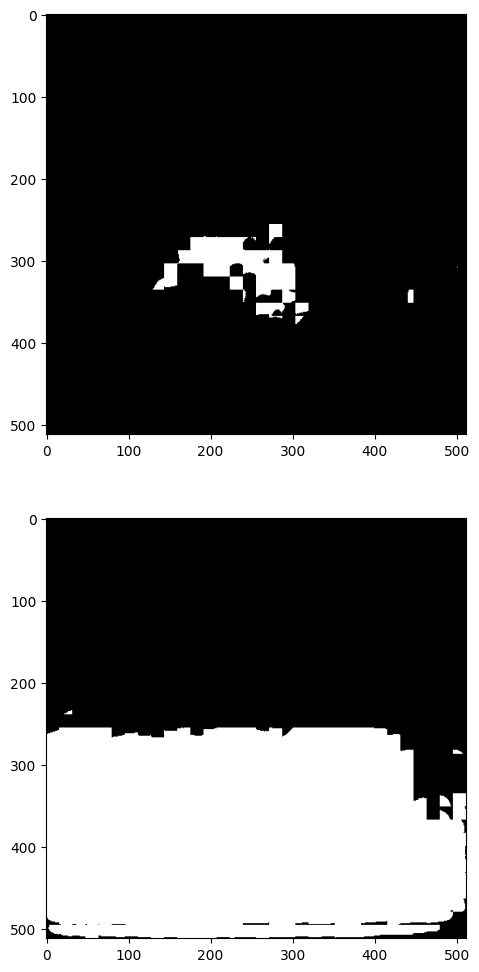

In [29]:
files = ['wide_angle_camera_front_1677756692_626864514.png']
obstacle_word_mask = 'A dull photo of obstacles'
prompt = 'A bright picture of a narrow footpath'
for i, file in enumerate(files):

  if i >= road_start_index and i<=N-road_end_index:
    word_mask = 'A dull photo of a road to walk on'
  else:
    word_mask = 'A dull photo of a path through the grass'
  print(f'mask : {word_mask}, number : {i}')
  img = Image.open(os.path.join(path,file))

  # prompt clipseg
  mask_path, init_image = prompt_clipseg(prompt=None, image=img, word_mask=word_mask)
  mask_obstacle, _ = prompt_clipseg(prompt=None, image=img, word_mask=obstacle_word_mask)
  # add masks
  mask_obstacle = np.asarray(mask_obstacle)
  mask_path = np.asarray(mask_path)
  mask = np.copy(mask_path)
  
  plt.figure(figsize=(12,12))
  plt.subplot(2,1,1)
  plt.imshow(np.asarray(mask_obstacle))
  plt.subplot(2,1,2)
  plt.imshow(mask_path)
  
  for y, elem in enumerate(mask_obstacle):
    for x, elem_ in enumerate(mask_obstacle):
      if (mask_path[y][x] == [255,255,255]).all() and (mask_obstacle[y][x] == [255,255,255]).all():
        mask[y][x] = [0,0,0]
  
  # prompt SD inpainting
  output = prompt_SD_inpainting(prompt=prompt, image=init_image, clipseg_mask=mask_path)
  # prompt clipseg
  masked_image, _ = prompt_clipseg(prompt=None, image=output.images[0], word_mask=prompt)
  masked_image = cv2.add(np.asarray(init_img), np.asarray(masked_image))

  plt.figure(figsize=(12,12))
  plt.subplot(2,2,1)
  plt.title('Initial Image')
  plt.imshow(np.asarray(init_img))
  plt.subplot(2,2,2)
  plt.title(f'Mask - {word_mask}')
  plt.imshow(mask)
  plt.subplot(2,2,3)
  plt.title(f'SD Output - {prompt}')
  plt.imshow(output.images[0])
  plt.subplot(2,2,4)
  plt.title(f'Masked Image')
  plt.imshow(masked_image)
  #images_dir = './processed_hike'
  #plt.savefig(f"{images_dir}/{file}")
